|  Surname | Name   | Matricola   | Accademic Mail   |
|---|---|---|---|
|Rossetto   | Eric     | 982594    | eric.rossetto@studio.unibo.it |
|Wen          | Xiaowei   | 982501  | xiaowei.wen@studio.unibo.it  |  


MSc student in Artificial Intelligence
@ Alma Mater Studiorum, University of Bologna  
August, 2021

# Importing libraries

In [1]:
from z3 import *
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import matplotlib.patches as mpatches
import time
import json

# Defining functions 

In [2]:
def read_instance_text(f):
    """ 
    It reads the instance data, in the following format:
    width
    n_circuits
    Wi, Hi for i in range(n_circuits)
    returns a tuple as (width, List of Wi, List of Hi)
    """
    # print(f)
    file = open(f)
    w = int(file.readline())
    # print("width ", width)
    n_piece = int(file.readline())
    W, H = [], []
    for i in range(n_piece):
        piece = file.readline()
        split_piece = piece.strip().split(" ")
        W.append((int(split_piece[0])))
        H.append((int(split_piece[1])))
    # print(pieces)
    return w, W, H


def show_shape(s, title, n_circuits):
    """
    create a image with s as image and title as title of the graph
    :param s:
    :param title:
    :param n_circuits:
    :return:
    """
    s = cv2.merge([s])
    img = plt.imshow(s)

    values, counts = np.unique(s, return_counts=True)
    # print(counts)
    colors = [img.cmap(img.norm(value)) for value in values]
    labels = []
    starting = 0
    if n_circuits + 1 == len(counts):
        starting = 1
        labels.append("Background")
    for i in range(starting, len(counts)):
        labels.append(f"Piece {i + 1}")
    patches = [mpatches.Patch(color=colors[i], label=labels[i]) for i in range(len(counts))]
    plt.title(title)
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xticks(list(range(0, s.shape[1] + 1)))
    yticks = list(range(0, s.shape[0]))
    # yticks.reverse()
    plt.yticks(yticks)
    plt.ylim(top=s.shape[0])
    plt.ylim(bottom=-0.5)
    plt.xlim(left=-0.5)
    plt.xlim(right=s.shape[1])
    plt.gca().invert_yaxis()
    # plt.grid(b=True)
    # plt.savefig(f"{title}")

    plt.show()


def draw_solution(sol_shape, pieces):
    """
    Returns an array with shape = sol_shape, and pieces drawn in the array
    """
    arr = np.zeros(sol_shape)
    count = 1
    # area = 0
    for x_t, y_t, x, y, rot in pieces:
        if rot == 0:
            arr[x:x + x_t, y:y + y_t] = abs(count) * (255 / len(pieces))
        else:
            arr[x:x + y_t, y:y + x_t] = abs(count) * (255 / len(pieces))
        count += 1
    arr = arr / np.max(arr)
    return np.rot90(arr)


def dims_sol_unify(W, H, X, Y, R):
    """
    It creates a list of tuple, where each tuple is composed by
    (Wi,Hi,Xi,Yi)
    :param W: width of the piece i
    :param H: height of the piece i
    :param X: X component of the piece i
    :param Y: Y component of the piece i
    :return:
    """
    return [(W[i], H[i], X[i], Y[i], R[i]) for i in range(len(W))]


def flatten(t):
    """
    Given a list of lists, it returns a flatten version of all lists
    :param t:
    :return:
    """
    return [item for sublist in t for item in sublist]


def save_sol(file_name, w, h, W, H, X, Y, R):
    """
    Save the solution in file file_name
    :param file_name: path to the file
    :param w: width of the solution
    :param h: height of the solution
    :param W: width of the piece i
    :param H: height of the piece i
    :param X: X component of the piece i
    :param Y: Y component of the piece i
    :return:
    """
    file = open(file_name, mode="w")
    file.write(f"{w} {h}\n")
    file.write(f"{len(X)}\n")
    for i in range(len(W)):
        file.write(f"{W[i]} {H[i]} {X[i]} {Y[i]} {R[i]}\n")
    file.close()


def check_sat_rot(sol_dim, coordinates):
    """
    Given the coordinates, check whether they satisfy the no overlapping conditions.
    :param coordinates:
    :param sol_dim:
    :return:
    """
    for i in range(len(coordinates)):
        x_t, y_t, x, y, rot = coordinates[i]
        if rot == 0:
            if x + x_t <= sol_dim[0] and y + y_t <= sol_dim[1] is False:
                print("Solution goes out of boundaries.")
                return False
        else:  # rot ==1:
            if x + y_t <= sol_dim[0] and y + x_t <= sol_dim[1] is False:
                print("Solution goes out of boundaries.")
                return False

    sat = True
    for i in range(len(coordinates)):
        for j in range(len(coordinates)):
            if i != j:
                xt_i, yt_i, x_i, y_i, rot_i = coordinates[i]
                xt_j, yt_j, x_j, y_j, rot_j = coordinates[j]
                if x_i < x_j and x_i + rot_i * yt_i + (1 - rot_i) * xt_i <= x_j:
                    continue
                elif y_i < y_j and y_i + rot_i * xt_i + (1 - rot_i) * yt_i <= y_j:
                    continue
                elif x_i > x_j and x_i - rot_j * yt_j - (1 - rot_j) * xt_j >= x_j:
                    continue
                elif y_i > y_j and y_i - rot_j * xt_j - (1 - rot_j) * yt_j >= y_j:
                    continue
                else:
                    print(coordinates[i], coordinates[j])
                    sat = False
    return sat

# Defining function for SMT instance

In [3]:
def vlsi_instance(W, H, dims, width, max_height, time_out = 300):
  """
    Variable declaration
    W: width of all circuits
    H: height of all circuits
    dims: number of circuits
    width: width of the board/ solution
    max_height: maximum height reachable by stacking all circuits. 
    time_out: timeout for the solver in seconds
  """
  # decision variable for the height
  all_constraints = []
  height = Int('height')

  rot = [Int(f"rot_{i}") for i in range(dims)]
  rotation_cons = [And(rot[i]>=0, rot[i]<=1) for i in range(dims)]
  all_constraints += rotation_cons

  # X component of the solution where to place the circuits
  X = [Int(f"X_{i}") for i in range(dims)]
  
  # Y component of the solution where to place the circuits
  Y = [Int(f"Y_{i}") for i in range(dims)]

  # width boundaries constraints
  boundaries_c_width = [And(0 <= X[i], X[i] +(1 - rot[i]) * W[i] +  rot[i]*H[i] <= width) for i in range(dims)]
  all_constraints+= boundaries_c_width

  # height boundaries constraints
  boundaries_c_height = [0 <= Y[i] for i in range(dims)] 
  all_constraints += boundaries_c_height
  
  # height constraints
  height_constraint = [Y[i] + (1 - rot[i]) * H[i] + rot[i] * W[i]  <= height for i in range(dims)]
  all_constraints += height_constraint

  biggest_H = int(np.argmax(H))
  # symmetry breaking 
  all_constraints +=  [And(X[biggest_H]*2 <=width,Y[biggest_H]*2 <=width)]

  # height constraints
  height_constraint = [Y[i]+H[i]<=height for i in range(dims)]
  all_constraints += height_constraint

  # no overlapping constraints
  no_overlapping = []    
  for i in range(dims):
    for j in range(dims):
      if i != j:
        no_overlapping.append(
                Or(
                X[i] + rot[i] * H[i] + (1 - rot[i]) * W[i] <= X[j],
                Y[i] + rot[i] * W[i] + (1 - rot[i]) * H[i] <= Y[j],
                X[i] - rot[j] * H[j] - (1 - rot[j]) * W[j] >= X[j],
                Y[i] - rot[j] * W[j] - (1 - rot[j]) * H[j] >= Y[j])) 
  all_constraints += no_overlapping

  """
    Solving phase
  """
  solver = Optimize()
  # print(str(all_constraints))
  solver.add(all_constraints)
  # minimizing function
  if time_out != -1:
    solver.set("timeout",time_out*1000)
  solver.minimize(height)
  if solver.check() == sat:
    m = solver.model()
    return int(m.evaluate(height).as_string()), [int(m.evaluate(X[i]).as_string()) for i in range(dims)], \
    [int(m.evaluate(Y[i]).as_string()) for i in range(dims)], \
    [int(m.evaluate(rot[i]).as_string()) for i in range(dims)]
  else:
    print(solver.reason_unknown())
    return None



# Solving
## reading solution time per instance

In [4]:
time_table = "time_rot.json"
time_per_instance = []
with open(time_table, "r") as f:
    time_json = json.load(f)

## Getting instances 

In [5]:
path = "../../instances/"
# solve all instances in path
instances = os.listdir(path)

# solve a certain range of the instances
# instances = [f"ins-{i}.txt" for i in range (11,41)]

# solve a specified instance
# instances = [f"ins-{11}.txt"]

# solve those unsolved instances
# instances = []
# for key, value in time_json.items():
#   if value == -1:
#     instances.append(key)


## Solving instances

Instance 1:
(8, [0, 0, 3, 3], [5, 0, 0, 3], [0, 0, 0, 0])
Solution (width, height): (8, 8), time: 0.1267s


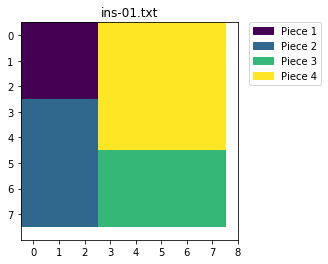

Instance 2:
(9, [6, 0, 0, 6, 3], [0, 5, 0, 3, 0], [0, 0, 0, 0, 0])
Solution (width, height): (9, 9), time: 0.1925s


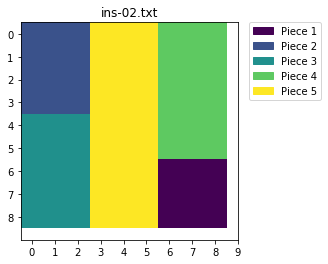

Instance 3:
(10, [0, 3, 3, 0, 6, 6], [7, 0, 4, 0, 0, 4], [0, 0, 0, 0, 0, 0])
Solution (width, height): (10, 10), time: 0.402s


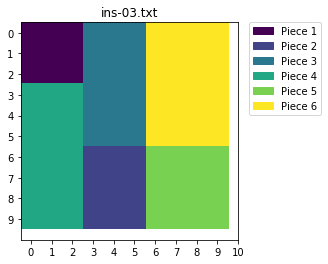

Instance 4:
(11, [8, 5, 0, 5, 8, 0, 0], [3, 7, 0, 0, 6, 7, 3], [0, 0, 1, 1, 1, 0, 0])
Solution (width, height): (11, 11), time: 1.3444s


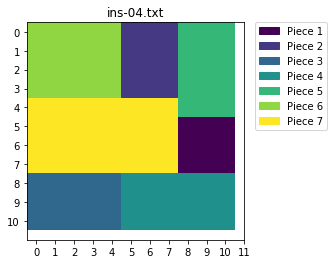

Instance 5:
(12, [6, 9, 0, 6, 0, 9, 3, 3], [0, 8, 0, 3, 5, 0, 0, 9], [0, 0, 0, 0, 0, 0, 0, 0])
Solution (width, height): (12, 12), time: 2.5308s


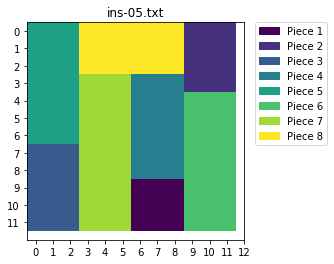

Instance 6:
(13, [6, 9, 3, 0, 0, 3, 10, 6, 6], [6, 6, 8, 0, 6, 0, 9, 9, 0], [0, 1, 0, 0, 0, 0, 1, 0, 0])
Solution (width, height): (13, 13), time: 4.6775s


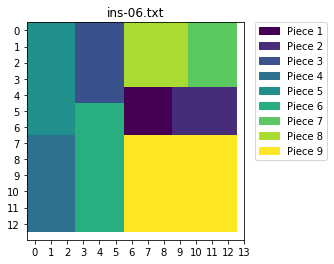

Instance 7:
(14, [11, 8, 5, 8, 8, 11, 5, 0, 0], [11, 3, 0, 0, 7, 3, 5, 10, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0])
Solution (width, height): (14, 14), time: 3.6811s


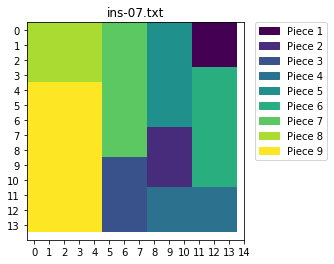

Instance 8:
(15, [0, 6, 0, 9, 0, 6, 6, 12, 3, 9], [12, 3, 0, 3, 5, 7, 0, 3, 0, 9], [0, 0, 0, 0, 0, 0, 1, 0, 0, 1])
Solution (width, height): (15, 15), time: 1.0981s


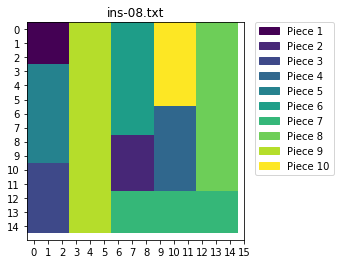

Instance 9:
(16, [13, 0, 0, 10, 13, 0, 10, 4, 3, 3], [13, 0, 11, 3, 6, 3, 6, 0, 3, 7], [0, 1, 0, 1, 0, 0, 0, 1, 1, 0])
Solution (width, height): (16, 16), time: 2.3125s


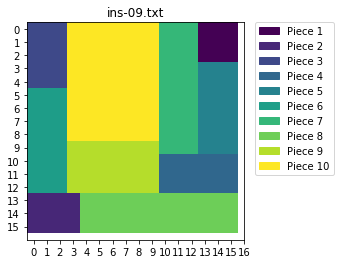

Instance 10:
(17, [0, 3, 0, 3, 3, 14, 0, 13, 10, 6, 6, 10], [14, 6, 0, 0, 10, 0, 5, 14, 0, 0, 14, 8], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Solution (width, height): (17, 17), time: 131.9105s


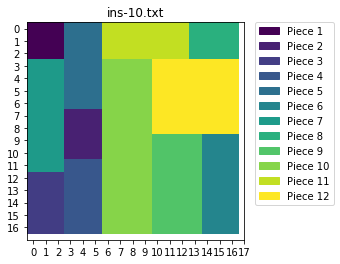

Instance 11:


In [6]:
for i in range(len(instances)):
    # print(path+instance)
    instance = instances[i]
    print(f"Instance {i+1}:")
    width, W, H = read_instance_text(path + instance)
    # print(dims)
    max_height = np.sum([H[i] for i in range(len(H))], dtype=int)
    # print(f"Maximum height reachable: {max_height}")

    start_time = time.time_ns()
    returned_value = vlsi_instance(W, H, len(W), width, max_height)
    if returned_value is not None:
        height, X, Y, rot = returned_value
        end_time = time.time_ns()
        end_time = (end_time - start_time) / 10 ** 9
        print(f"Solution (width, height): {width, height}, time: {round(end_time, 4)}s")
        print(returned_value)
        time_json[instance] = end_time

        # showing solutions
        solutions = dims_sol_unify(W, H, X, Y, rot)
        save_sol("rot_sol/" + instance.replace("ins", "sol"), width, height, W, H, X, Y, rot)
        # print(check_sat_rot((width,height), solutions))
        arr = draw_solution((width, height), solutions)
        show_shape(arr, instance, len(W))
    else:
        time_json[instance] = -1


## Saving time table

In [ ]:
with open(time_table, "w") as outfile:
    data = json.dumps(time_json, indent=4, sort_keys=True)
    outfile.write(data)

## Performance Analysis

In [ ]:
acc = 0
counter = 0
for k,v in time_json.items():
    if v != -1:
        acc +=v
        counter+=1

print(f"Number of successfully solved instances: {counter}")
print(f"Average time per instance: {np.round(acc/counter,decimals=2)}/s")



# of successfully solved instances: 10
Average time per instance: 106.59/s
